# SSD512 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD512 for inference on the Pascal VOC datasets. It is the same as the SSD300 inference tutorial but with all parameters preset for SSD512 for Pascal VOC. If you'd like more detailed explanations on how to use the model generally, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [ ]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

In [ ]:
# Set the image size.
img_height = 512
img_width = 512

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [ ]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_512(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
               two_boxes_for_ar1=True,
               steps=[8, 16, 32, 64, 128, 256, 512],
               offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               clip_boxes=False,
               variances=[0.1, 0.1, 0.2, 0.2],
               normalize_coords=True,
               subtract_mean=[123, 117, 104],
               swap_channels=[2, 1, 0],
               confidence_thresh=0.5,
               iou_threshold=0.45,
               top_k=200,
               nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'path/to/trained/weights/VGG_VOC0712_SSD_512x512_iter_120000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Or

### 1.2. Load a trained model

In [3]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd512_pascal_07+12_epoch-97_loss-1.6660_val_loss-1.7322.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

W0403 08:16:00.218719 139921814058752 deprecation.py:323] From /root/ssd_keras/keras_loss_function/keras_ssd_loss.py:133: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0403 08:16:00.265661 139921814058752 deprecation.py:323] From /root/ssd_keras/keras_loss_function/keras_ssd_loss.py:166: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [4]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'datasets/VOC2007/JPEGImages/00033_004020_1_014224_1492606325.4380782.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img)
input_images.append(img)
input_images = np.array(input_images)

## 3. Make predictions

In [5]:
y_pred = model.predict(input_images)

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [6]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

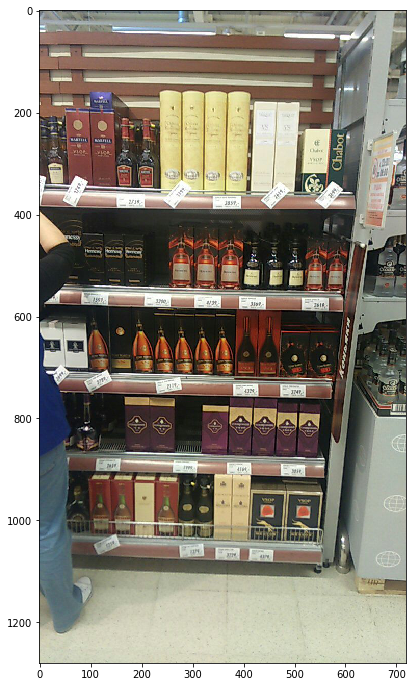

In [7]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background', 'Джим Бим', 'Джим Бим Apple', 'Джим Бим Черри', 'Курвуазье VS', 'Курвуазье VSOP', 'Сауза Голд', 'Сауза Сильвер']


plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
    xmin = box[-4] * orig_images[0].shape[1] / img_width
    ymin = box[-3] * orig_images[0].shape[0] / img_height
    xmax = box[-2] * orig_images[0].shape[1] / img_width
    ymax = box[-1] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

## 5. Make predictions on Pascal VOC 2007 Test

Let's use a `DataGenerator` to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [8]:
# Create a `BatchGenerator` instance and parse the Pascal VOC labels.

dataset = DataGenerator()

# TODO: Set the paths to the datasets here.

VOC_2007_images_dir         = 'datasets/VOC2007/JPEGImages/'
VOC_2007_annotations_dir    = 'datasets/VOC2007/Annotations/'
VOC_2007_test_image_set_filename = 'datasets/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background', 'Джим Бим', 'Джим Бим Apple', 'Джим Бим Черри', 'Курвуазье VS', 'Курвуазье VSOP', 'Сауза Голд', 'Сауза Сильвер']


dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                  image_set_filenames=[VOC_2007_test_image_set_filename],
                  annotations_dirs=[VOC_2007_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=True,
                  ret=False)

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=False)

Processing image set 'test.txt': 100%|██████████| 139/139 [00:01<00:00, 134.46it/s]


In [152]:
# Generate a batch and make predictions.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
for n in np.array(batch_original_labels[i]):
    print(classes[n[0]])
print(np.array(batch_original_labels[i]))

Image: datasets/VOC2007/JPEGImages/00028_003325_1_011581_1492409824.414469.jpg

Ground truth boxes:

Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Голд
Сауза Голд
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
[[  6 262 210 306 352]
 [  6 304 211 344 351]
 [  6 345 212 380 351]
 [  6 380 211 422 351]
 [  7 424 205 462 351]
 [  7 463 206 503 347]
 [  7 503 205 543 347]
 [  7 545 204 588 345]
 [  7 589 206 632 346]
 [  6 373 424 419 571]
 [  6 420 423 464 571]
 [  7 465 423 512 571]
 [  7 511 423 559 571]
 [  7 559 422 604 571]
 [  7 604 422 651 570]
 [  7 652 421 700 571]
 [  6 303 635 346 780]
 [  6 347 634 390 781]
 [  6 390 635 435 782]
 [  7 478 631 523 780]
 [  7 523 631 56

In [153]:
# Predict.

y_pred = model.predict(batch_images)

In [154]:
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

y_pred_thresh_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
for n in y_pred_thresh_inv[i]:
    print(classes[int(n[0])])
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

Predicted boxes:

Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Голд
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
Сауза Сильвер
   class   conf xmin   ymin   xmax   ymax
[[  6.     1.   345.   633.   389.   777.  ]
 [  6.     1.   301.   636.   344.   777.  ]
 [  6.     1.   443.   833.   494.   982.  ]
 [  6.     1.   387.   630.   434.   778.  ]
 [  6.     1.   301.   205.   342.   352.  ]
 [  6.     1.   417.   419.   462.   568.  ]
 [  6.     1.   370.   415.   418.   572.  ]
 [  6.     0.99 305.   827.   352.   978.  ]
 [  6.     0.99 342.   204.   383.   350.  ]
 [  6.     0.99 397.   830.   446.   982.  ]
 [  6.     0.99 261.   201.   302.   352.  ]
 [  6.     0.99 351.  

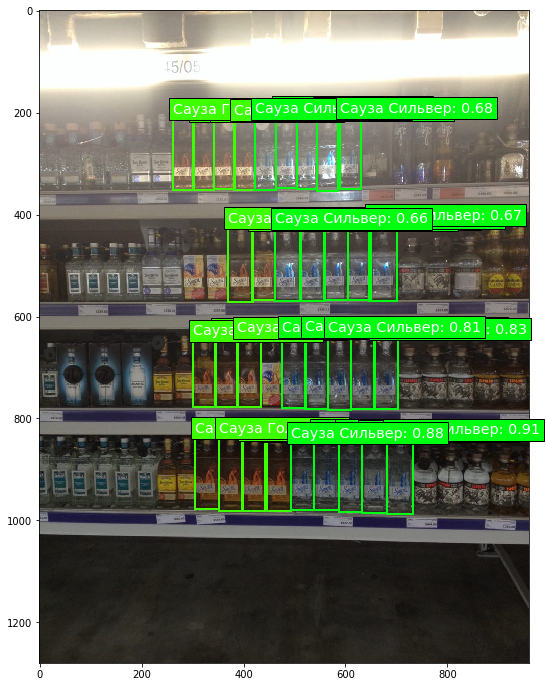

In [155]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

# for box in batch_original_labels[i]:
#     xmin = box[1]
#     ymin = box[2]
#     xmax = box[3]
#     ymax = box[4]
#     label = '{}'.format(classes[int(box[0])])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})